# Comparaison de performances d'attaques adverses (CIFAR-10)

In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
from os.path import join


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf



from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7,EfficientNetB0,EfficientNetB6
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

#### 1. Load Data

In [4]:
(X_train, y_train), (X_test, y_test), min, max=load_dataset('cifar10')

In [7]:
dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

#### 2. Load models

In [20]:
effnet_base= EfficientNetB7(include_top=False,weights='imagenet',classes = 10, input_shape=(32, 32, 3))
effnet_base.trainable=True
x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-3].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10,name='fc_2')(x)
o = Activation('softmax', name='act_2')(x)
model_effnet = Model(inputs=effnet_base.input, outputs=[o])

In [21]:
training_effnet=True

if training_effnet==True:
    model_effnet.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_effnet.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    model_effnet.save('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    
else:
    model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
  128/45000 [..............................] - ETA: 7:07:56

ResourceExhaustedError:  OOM when allocating tensor with shape[128,2304,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_5/block6g_dwconv/depthwise (defined at <ipython-input-21-e2dc1bb13c8a>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_377375]

Errors may have originated from an input operation.
Input Source operations connected to node model_5/block6g_dwconv/depthwise:
 model_5/block6g_expand_activation/mul (defined at /home/timotheerio/adversarial_attakcs_benchmark/venv/lib/python3.6/site-packages/efficientnet/model.py:115)

Function call stack:
distributed_function


In [25]:
VGG_base=applications.VGG16(include_top=False, weights='imagenet',input_shape=(32, 32, 3)) 
VGG_base.trainable=False
x = GlobalMaxPooling2D(name='pool_1')(VGG_base.layers[-2].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10)(x)
o = Activation('softmax', name='act_2')(x)
model_vgg = Model(inputs=VGG_base.input, outputs=[o])

In [15]:
training_vgg=True
if training_vgg==True:
    model_vgg.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_vgg.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    #model_vgg.save('/media/hdd1/benchmark_adversarial_attacks/vgg_model_cifar.h5')
    
else:
    model_vgg=load_model('/media/hdd1/benchmark_adversarial_attacks/vgg_model_cifar.h5')
    

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 8s 168us/sample - loss: 1.6550 - accuracy: 0.4217 - val_loss: 1.3642 - val_accuracy: 0.5318
Epoch 2/5
18176/45000 [===========>..................] - ETA: 3s - loss: 1.4232 - accuracy: 0.5111

KeyboardInterrupt: 

In [10]:
small_model = tf.keras.models.Sequential()
small_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Conv2D(64, (3, 3), activation='relu'))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Flatten())
small_model.add(Dense(128, activation='relu'))
small_model.add(Dense(10, activation='softmax'))


small_model.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
    )

history = small_model.fit(X_train, y_train,
              epochs=5,
              batch_size = 128,
              validation_split=0.1,
              shuffle=True,
              verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 4s 83us/sample - loss: 1.5899 - accuracy: 0.4324 - val_loss: 1.2428 - val_accuracy: 0.5612
Epoch 2/5
45000/45000 [==============================] - 3s 68us/sample - loss: 1.1788 - accuracy: 0.5849 - val_loss: 1.1363 - val_accuracy: 0.6060
Epoch 3/5
45000/45000 [==============================] - 3s 69us/sample - loss: 1.0261 - accuracy: 0.6423 - val_loss: 1.0064 - val_accuracy: 0.6552
Epoch 4/5
45000/45000 [==============================] - 3s 69us/sample - loss: 0.9244 - accuracy: 0.6777 - val_loss: 0.9591 - val_accuracy: 0.6776
Epoch 5/5
45000/45000 [==============================] - 3s 68us/sample - loss: 0.8405 - accuracy: 0.7062 - val_loss: 0.9929 - val_accuracy: 0.6578


#### 3. Performances comparison


In [11]:
y_pred_small_model=[dict_classes[np.argmax(pred)] for pred in small_model.predict(X_test)]
y_true=[dict_classes[np.argmax(y)] for y in y_test]
classification_small_model=classification_report(y_true, y_pred_small_model)
print(classification_small_model)

              precision    recall  f1-score   support

    airplane       0.80      0.61      0.70      1000
  automobile       0.61      0.91      0.73      1000
        bird       0.72      0.33      0.45      1000
         cat       0.60      0.34      0.43      1000
        deer       0.49      0.72      0.59      1000
         dog       0.61      0.55      0.58      1000
        frog       0.58      0.90      0.70      1000
       horse       0.79      0.69      0.73      1000
        ship       0.71      0.81      0.75      1000
       truck       0.80      0.64      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.67      0.65      0.64     10000
weighted avg       0.67      0.65      0.64     10000



In [12]:
y_pred_VGG=[dict_classes[np.argmax(pred)] for pred in model_vgg.predict(X_test)]
y_true=[dict_classes[np.argmax(y)] for y in y_test]
classification_VGG=classification_report(y_true, y_pred_VGG)
print(classification_VGG)

              precision    recall  f1-score   support

    airplane       0.58      0.69      0.63      1000
  automobile       0.64      0.58      0.61      1000
        bird       0.52      0.37      0.43      1000
         cat       0.41      0.42      0.42      1000
        deer       0.52      0.54      0.53      1000
         dog       0.51      0.49      0.50      1000
        frog       0.60      0.64      0.62      1000
       horse       0.63      0.59      0.61      1000
        ship       0.69      0.63      0.66      1000
       truck       0.53      0.66      0.58      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



In [17]:
y_pred_eff=[dict_classes[np.argmax(pred)] for pred in model_effnet.predict(X_test)]
y_true=[dict_classes[np.argmax(y)] for y in y_test]
classification_eff=classification_report(y_true, y_pred_eff)
print(classification_eff)

              precision    recall  f1-score   support

    airplane       0.52      0.55      0.54      1000
  automobile       0.58      0.56      0.57      1000
        bird       0.40      0.38      0.39      1000
         cat       0.35      0.35      0.35      1000
        deer       0.49      0.45      0.47      1000
         dog       0.41      0.57      0.47      1000
        frog       0.56      0.66      0.60      1000
       horse       0.61      0.47      0.53      1000
        ship       0.52      0.63      0.57      1000
       truck       0.70      0.37      0.48      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.50     10000
weighted avg       0.51      0.50      0.50     10000



#### 4. Load attacks 

In [78]:
def contrast_enhancer(image_noise):    
    for i in range (3):
        color_axis=image_noise[:,:,i]
        color_axis =((color_axis -np.min(color_axis))/np.ptp(color_axis))
        image_noise[:,:,i]=color_axis
    image_noise=image_noise #in order to have the darker colors corresponding to the biggest changes
    return(image_noise)

Let's define the peformances metrics

In [19]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

In [29]:
model_to_fool = TensorFlowModel(model_effnet, bounds=(0, 255))


attack_deepfool_1_steps=LinfDeepFoolAttack(steps=1)
attack_deepfool_mutliple_steps=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()


#### 5. Attacks performances

In [1]:
def attack_performances_computer(model_to_fool,attack, image_list, labels,epsilon):
    success=[]
    adv_list=[]
    attack_value=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        success.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
        prediction=model_effnet.predict(np.expand_dims(clipped[0][0],axis=0))           
        attack_value+=[np.argmax(prediction)]
    DOC_attack=DOC(adv_list,image_list)
    SR_attack=succes_rate(success)
    return(DOC_attack,SR_attack)

y_true=list(map(np.argmax,y_test))


NameError: name 'np' is not defined

##### Comparison FGSM vs deepfool 1 step vs deepfool mutliple steps on effnet

The success rate with 5 steps is the same than with one step, however the DOC is slightly better (lower) with one step. 

In [32]:
epislons_list=[0.001,0.005,0.05,0.5,1,10]

y_true=list(map(np.argmax,y_test))

SR_FGSM_dic={}
SR_deepfool_1step_dic={}
SR_deepfool_mutliple_steps_dic={}
DOC_FGSM_dic={}
DOC_deepfool_1step_dic={}
DOC_deepfool_mutliple_steps_dic={}

for epsilon in epislons_list:
    print('======'+str(epsilon)+'======')
    DOC_FGSM,SR_FGSM=attack_performances_computer(model_to_fool,attack_FGSM, X_test[:100], y_true[:100],[epsilon])
    DOC_deepfool_1step,SR_deepfool_1step=attack_performances_computer(model_to_fool,attack_deepfool_1_steps, X_test[:100], y_true[:100],[epsilon])
    DOC_deepfool_mutliple_steps,SR_deepfool_mutliple_steps=attack_performances_computer(model_to_fool,attack_deepfool_mutliple_steps, X_test[:100], y_true[:100],[epsilon])
    
    SR_deepfool_1step_dic[epsilon]=SR_deepfool_1step
    DOC_deepfool_1step_dic[epsilon]=DOC_deepfool_1step
    SR_deepfool_mutliple_steps_dic[epsilon]=SR_deepfool_mutliple_steps
    DOC_deepfool_mutliple_steps_dic[epsilon]=DOC_deepfool_mutliple_steps
    SR_FGSM_dic[epsilon]=SR_FGSM
    DOC_FGSM_dic[epsilon]=DOC_FGSM
    

  0%|          | 0/100 [00:00<?, ?it/s]

======0.001======


  0%|          | 0/100 [00:00<?, ?it/s]

======0.005======


  0%|          | 0/100 [00:00<?, ?it/s]

======0.05======


  0%|          | 0/100 [00:00<?, ?it/s]

======0.5======


  0%|          | 0/100 [00:00<?, ?it/s]

======1======


  0%|          | 0/100 [00:00<?, ?it/s]

======10======


100%|██████████| 100/100 [18:27<00:00, 11.07s/it]


In [33]:
# with open('perf_deepfool_1step_cifar', 'wb') as f:
#     pickle.Pickler(f).dump(SR_deepfool_1step_dic)
# with open('perf_deepfool_1step_cifar', 'ab') as f:
#     pickle.Pickler(f).dump(DOC_deepfool_1step_dic)
    

# with open('perf_FGSM_cifar', 'wb') as f:
#     pickle.Pickler(f).dump(SR_FGSM_dic)
# with open('perf_FGSM_cifar', 'ab') as f:
#     pickle.Pickler(f).dump(DOC_FGSM_dic)
    
    
# with open('perf_deepfool_mutliple_steps_cifar', 'wb') as f:
#     pickle.Pickler(f).dump(SR_deepfool_mutliple_steps_dic)
# with open('perf_deepfool_mutliple_steps_cifar', 'ab') as f:
#     pickle.Pickler(f).dump(DOC_deepfool_mutliple_steps_dic)

In [182]:
with open('perf_deepfool_1step_cifar', 'rb') as f:
    SR_deepfool_1step_dic=pickle.Unpickler(f).load()
    DOC_deepfool_1step_dic=pickle.Unpickler(f).load()
    

with open('perf_FGSM_cifar', 'rb') as f:
    SR_FGSM_dic=pickle.Unpickler(f).load()
    DOC_FGSM_dic=pickle.Unpickler(f).load()
    
    
with open('perf_deepfool_mutliple_steps_cifar', 'rb') as f:
    SR_deepfool_mutliple_steps_dic=pickle.Unpickler(f).load()
    DOC_deepfool_mutliple_steps_dic=pickle.Unpickler(f).load()
    
   

In [ ]:
plt.plot(list(DOC_deepfool_1step_dic.values()),list(SR_deepfool_1step_dic.values()),label='deepfool 1 step')
plt.plot(list(DOC_FGSM_dic.values()),list(SR_FGSM_dic.values()),label='FGSM')
plt.plot(list(DOC_deepfool_mutliple_steps_dic.values()),list(SR_deepfool_mutliple_steps_dic.values()),label='deepfool mutliple steps')
plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change on CIFAR-10 images', fontsize=8)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')
plt.show()

### Comparison FGSM vs deepfool 1 step vs deepfool mutliple steps on a small CNN

In [27]:
model_to_fool = TensorFlowModel(small_model, bounds=(0, 255))

attack_deepfool_1_step=LinfDeepFoolAttack(steps=1)
attack_deepfool_mutliple_steps=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()

In [28]:
epislons_list=[0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]

y_true=list(map(np.argmax,y_test))

SR_FGSM_dic_small={}
SR_deepfool_1step_dic_small={}
SR_deepfool_mutliple_steps_dic_small={}
DOC_FGSM_dic_small={}
DOC_deepfool_1step_dic_small={}
DOC_deepfool_mutliple_steps_dic_small={}

for epsilon in epislons_list:
    print('======'+str(epsilon)+'======')
    DOC_FGSM,SR_FGSM=attack_performances_computer(model_to_fool,attack_FGSM, X_test[:100], y_true[:100],[epsilon])
    DOC_deepfool_1step,SR_deepfool_1step=attack_performances_computer(model_to_fool,attack_deepfool_1_step, X_test[:100], y_true[:100],[epsilon])
    DOC_deepfool_mutliple_steps,SR_deepfool_mutliple_steps=attack_performances_computer(model_to_fool,attack_deepfool_mutliple_steps, X_test[:100], y_true[:100],[epsilon])
    
    SR_deepfool_1step_dic_small[epsilon]=SR_deepfool_1step
    DOC_deepfool_1step_dic_small[epsilon]=DOC_deepfool_1step
    SR_deepfool_mutliple_steps_dic_small[epsilon]= SR_deepfool_mutliple_steps
    DOC_deepfool_mutliple_steps_dic_small[epsilon]= DOC_deepfool_mutliple_steps
    SR_FGSM_dic_small[epsilon]=SR_FGSM
    DOC_FGSM_dic_small[epsilon]=DOC_FGSM

  0%|          | 0/100 [00:00<?, ?it/s]

======0.001======


 12%|█▏        | 12/100 [00:09<01:13,  1.20it/s]

KeyboardInterrupt: 

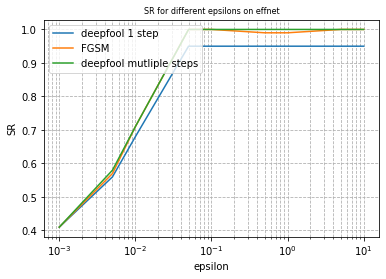

In [25]:
plt.plot(list(SR_deepfool_1step_dic_small.keys()),list(SR_deepfool_1step_dic_small.values()),label='deepfool 1 step')
plt.plot(list(SR_FGSM_dic_small.keys()),list(SR_FGSM_dic_small.values()),label='FGSM')
plt.plot(list(SR_deepfool_mutliple_steps_dic_small.keys()),list(SR_deepfool_mutliple_steps_dic_small.values()),label='deepfool mutliple steps')
plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('SR for different epsilons on effnet', fontsize=8)
plt.xlabel('epsilon')
plt.ylabel('SR')
plt.legend(loc='upper left')
plt.show()

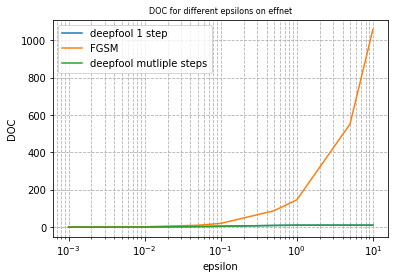

In [26]:
plt.plot(list(DOC_deepfool_1step_dic_small.keys()),list(DOC_deepfool_1step_dic_small.values()),label='deepfool 1 step')
plt.plot(list(DOC_FGSM_dic_small.keys()),list(DOC_FGSM_dic_small.values()),label='FGSM')
plt.plot(list(DOC_deepfool_mutliple_steps_dic_small.keys()),list(DOC_deepfool_mutliple_steps_dic_small.values()),label='deepfool mutliple steps')
plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC for different epsilons on effnet', fontsize=8)
plt.xlabel('epsilon')
plt.ylabel('DOC')
plt.legend(loc='upper left')
plt.show()